In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import warnings

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 12

In [23]:
def load_and_inspect_data(filepath):
    """
    Loads the NYC EV Charging dataset and performs initial type conversion.
    """
    try:
        df = pd.read_csv(filepath)

        # Convert timestamp to datetime
        df['connected_time_start_ts'] = pd.to_datetime(df['connected_time_start_ts'])

        # Sort chronologically
        df = df.sort_values(by='connected_time_start_ts').reset_index(drop=True)

        print(f"Dataset Loaded. Dimensions: {df.shape}")
        print(f"Date Range: {df['connected_time_start_ts'].min()} to {df['connected_time_start_ts'].max()}")
        return df
    except FileNotFoundError:
        print("Error: File not found. Please ensure 'EV_Charging_Data_NYC_Enhanced.csv' is in the directory.")
        return None

# Placeholder filename based on request
FILE_PATH = 'EV_Charging_Data_NYC_Enhanced.csv'
df = load_and_inspect_data(FILE_PATH)

Dataset Loaded. Dimensions: (206868, 19)
Date Range: 2021-07-31 09:58:31 to 2025-11-27 04:07:59


In [27]:
def preprocess_data(df):
    """
    Cleans the data by handling missing values, filtering outliers,
    and removing invalid sessions.
    """
    initial_rows = len(df)

    # 1. Filter Invalid Sessions
    # Sessions < 0.5 kWh are likely connection errors or testing.
    # We create a copy to avoid SettingWithCopy warnings.
    df_clean = df[df['energy_provided_kwh'] >= 0.5].copy()

    # 2. Handle Weather Data
    # Forward fill is statistically sound for weather (temp at 2pm is close to temp at 1pm)
    weather_cols = ['temp', 'humidity', 'tempmax', 'tempmin']
    for col in weather_cols:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].fillna(method='ffill')

    # 3. Filter Extreme Outliers
    # Remove top 1% of energy consumption to stabilize training (e.g., data errors > 200 kWh)
    cap_threshold = df_clean['energy_provided_kwh'].quantile(0.99)
    df_clean = df_clean[df_clean['energy_provided_kwh'] <= cap_threshold]

    # 4. Enforce categorical types for encoding
    cat_cols = ['station_name', 'location_name', 'driver_id', 'locality', 'conditions']
    for col in cat_cols:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].astype(str)

    # Add temporal features required for EDA
    df_clean['hour'] = df_clean['connected_time_start_ts'].dt.hour
    df_clean['day_of_week'] = df_clean['connected_time_start_ts'].dt.dayofweek

    dropped_rows = initial_rows - len(df_clean)
    print(f"Preprocessing Complete. Dropped {dropped_rows} rows ({(dropped_rows/initial_rows)*100:.2f}%).")
    return df_clean

df_clean = preprocess_data(df)

Preprocessing Complete. Dropped 6783 rows (3.28%).



--- Initiating Exploratory Data Analysis ---


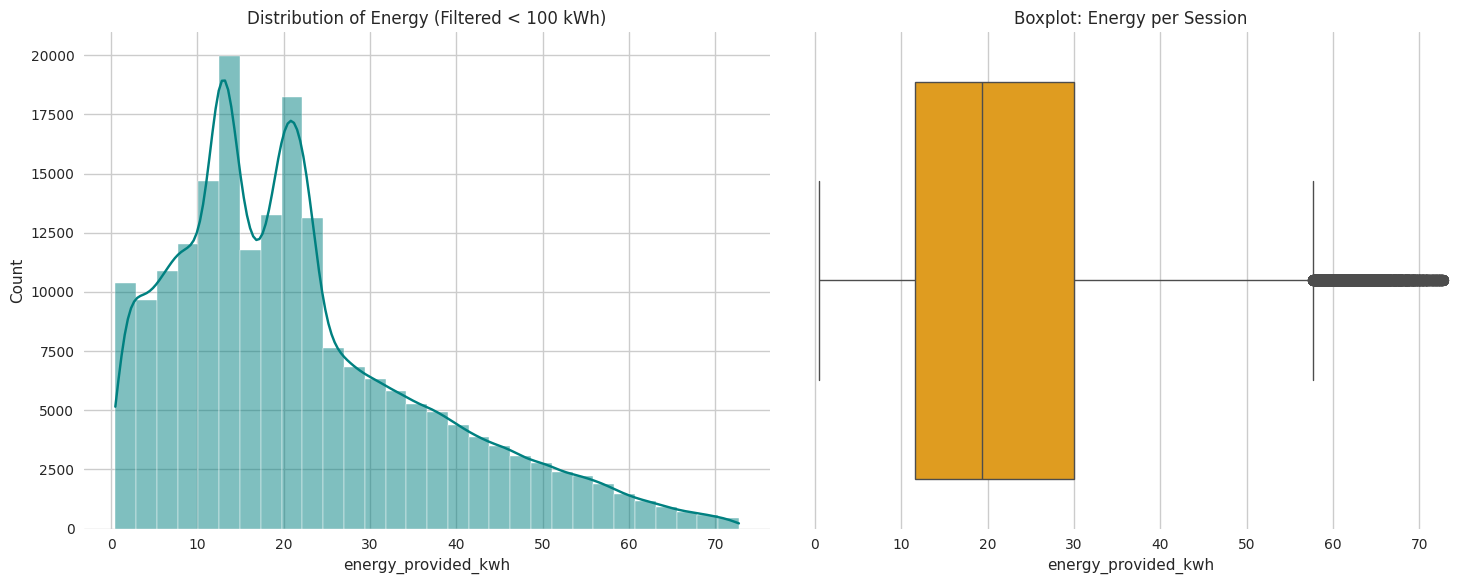

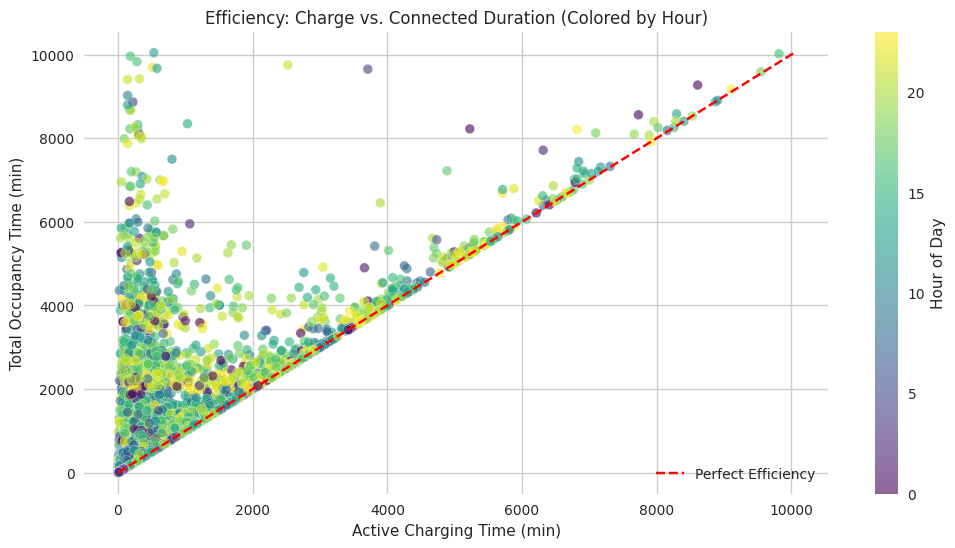

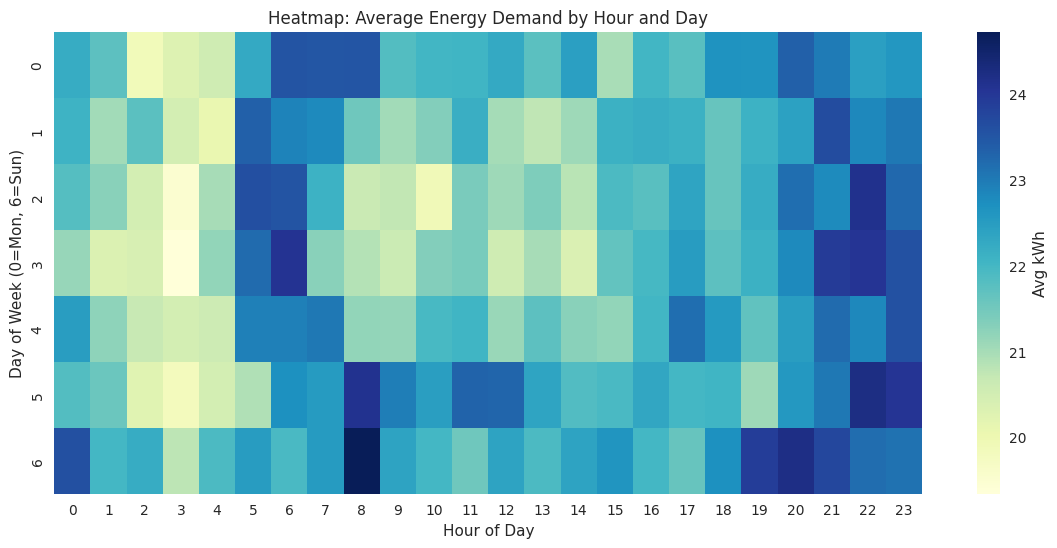

In [28]:
def perform_eda(df):
    """
    Generates insights on utilization efficiency, demand distribution,
    and temporal heatmaps.
    """
    print("\n--- Initiating Exploratory Data Analysis ---")

    # 2.1 Distribution of Energy with Boxplot (Outlier Detection)
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    sns.histplot(df['energy_provided_kwh'], bins=30, kde=True, color='teal', ax=ax[0])
    ax[0].set_title('Distribution of Energy (Filtered < 100 kWh)')

    sns.boxplot(x=df['energy_provided_kwh'], color='orange', ax=ax[1])
    ax[1].set_title('Boxplot: Energy per Session')
    plt.tight_layout()
    plt.show()

    # 2.2 Utilization Efficiency (Idle Time)
    plt.figure(figsize=(12, 6))
    plt.scatter(df['charge_duration_min'], df['connected_duration_min'], alpha=0.6, edgecolors='w', c=df['hour'], cmap='viridis')
    max_val = max(df['connected_duration_min'].max(), df['charge_duration_min'].max())
    plt.plot([0, max_val], [0, max_val], 'r--', label='Perfect Efficiency')
    plt.colorbar(label='Hour of Day')
    plt.title('Efficiency: Charge vs. Connected Duration (Colored by Hour)')
    plt.xlabel('Active Charging Time (min)')
    plt.ylabel('Total Occupancy Time (min)')
    plt.legend()
    plt.show()

    # 2.3 Temporal Heatmap: Hour vs Day of Week
    # We pivot the data to create a matrix of average energy demand
    pivot_table = df.pivot_table(index='day_of_week', columns='hour', values='energy_provided_kwh', aggfunc='mean')

    plt.figure(figsize=(14, 6))
    sns.heatmap(pivot_table, cmap='YlGnBu', annot=False, cbar_kws={'label': 'Avg kWh'})
    plt.title('Heatmap: Average Energy Demand by Hour and Day')
    plt.ylabel('Day of Week (0=Mon, 6=Sun)')
    plt.xlabel('Hour of Day')
    plt.show()

perform_eda(df_clean)

In [29]:
def engineer_features(df):
    """
    Generates predictive features from temporal, spatial, and user history data.
    """
    df_eng = df.copy()

    # 1. Temporal Features (Cyclical)
    df_eng['hour'] = df_eng['connected_time_start_ts'].dt.hour
    df_eng['month'] = df_eng['connected_time_start_ts'].dt.month
    df_eng['dayofweek'] = df_eng['connected_time_start_ts'].dt.dayofweek

    # Sine/Cosine transformations to handle 23:00 -> 00:00 continuity
    df_eng['hour_sin'] = np.sin(2 * np.pi * df_eng['hour'] / 24)
    df_eng['hour_cos'] = np.cos(2 * np.pi * df_eng['hour'] / 24)
    df_eng['month_sin'] = np.sin(2 * np.pi * df_eng['month'] / 12)
    df_eng['month_cos'] = np.cos(2 * np.pi * df_eng['month'] / 12)
    df_eng['day_sin'] = np.sin(2 * np.pi * df_eng['dayofweek'] / 7)
    df_eng['day_cos'] = np.cos(2 * np.pi * df_eng['dayofweek'] / 7)

    # 2. User Profiling (Target Encoding with Expanding Window)
    # Calculates the average energy a driver has consumed in ALL PRIOR sessions.
    # Shift(1) ensures the current session's energy is not included in the mean (Leakage Prevention).
    df_eng['user_hist_avg_energy'] = df_eng.groupby('driver_id')['energy_provided_kwh']\
                                         .transform(lambda x: x.shift(1).expanding().mean())

    # For new drivers (NaN), impute with global average
    global_mean = df_eng['energy_provided_kwh'].mean()
    df_eng['user_hist_avg_energy'].fillna(global_mean, inplace=True)

    # 3. Location & Categorical Encoding
    le = LabelEncoder()
    # Use fit_transform but handle cases where columns might be missing
    if 'station_name' in df_eng.columns:
        df_eng['station_id_enc'] = le.fit_transform(df_eng['station_name'])
    if 'location_name' in df_eng.columns:
        df_eng['location_id_enc'] = le.fit_transform(df_eng['location_name'])
    if 'locality' in df_eng.columns:
        df_eng['locality_enc'] = le.fit_transform(df_eng['locality'])
    if 'conditions' in df_eng.columns:
        df_eng['conditions_enc'] = le.fit_transform(df_eng['conditions'])

    # 4. Weather Interactions
    # Approximate "feels like" impact or thermal stress
    if 'temp' in df_eng.columns and 'humidity' in df_eng.columns:
        df_eng['temp_humid_interaction'] = df_eng['temp'] * df_eng['humidity']

    # 5. Feature Selection
    # We strictly EXCLUDE 'charge_duration_min', 'connected_duration_min', 'charge_duration_hours'
    # and 'disconnected_slot' as these are not known at the start of the session (Data Leakage).
    features = [
        'days_between_charges',
        'user_hist_avg_energy',
        'station_id_enc',
        'location_id_enc',
        'locality_enc',
        'conditions_enc',
        'hour_sin', 'hour_cos',
        'month_sin', 'month_cos',
        'day_sin', 'day_cos',
        'temp', 'humidity',
        'tempmax', 'tempmin',
        'temp_humid_interaction'
    ]

    # Filter only features that exist in dataframe (validating list against actual columns)
    features = [f for f in features if f in df_eng.columns]

    target = 'energy_provided_kwh'

    return df_eng[features], df_eng[target]

X, y = engineer_features(df_clean)

In [30]:
def train_evaluate_xgboost(X, y):
    """
    Trains XGBoost model using Time Series Split and evaluates performance.
    """
    # Use the last 20% of data for testing to respect temporal order
    split_point = int(len(X) * 0.8)

    X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
    y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

    print(f"Training Samples: {len(X_train)} | Test Samples: {len(X_test)}")

    # Initialize XGBoost Regressor
    # Hyperparameters derived from general best practices for tabular data
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        early_stopping_rounds=50,
        n_jobs=-1,
        random_state=42
    )

    # Train
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100
    )

    # Predict
    y_pred = model.predict(X_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("\n" + "="*30)
    print(f"FINAL EVALUATION METRICS")
    print("="*30)
    print(f"RMSE: {rmse:.4f} kWh")
    print(f"MAE:  {mae:.4f} kWh")
    print(f"R^2:  {r2:.4f}")

    return model, y_test, y_pred

model, y_test, y_pred = train_evaluate_xgboost(X, y)

Training Samples: 160068 | Test Samples: 40017
[0]	validation_0-rmse:14.73484	validation_1-rmse:14.54591
[100]	validation_0-rmse:11.38639	validation_1-rmse:12.11421
[121]	validation_0-rmse:11.32705	validation_1-rmse:12.12430

FINAL EVALUATION METRICS
RMSE: 12.1055 kWh
MAE:  8.8075 kWh
R^2:  0.3167


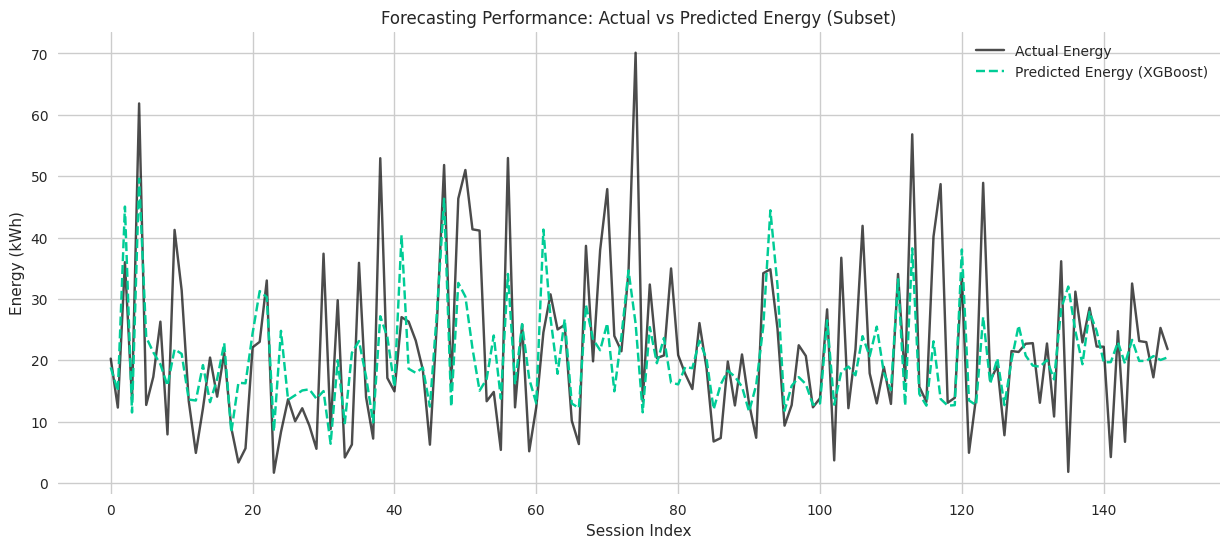

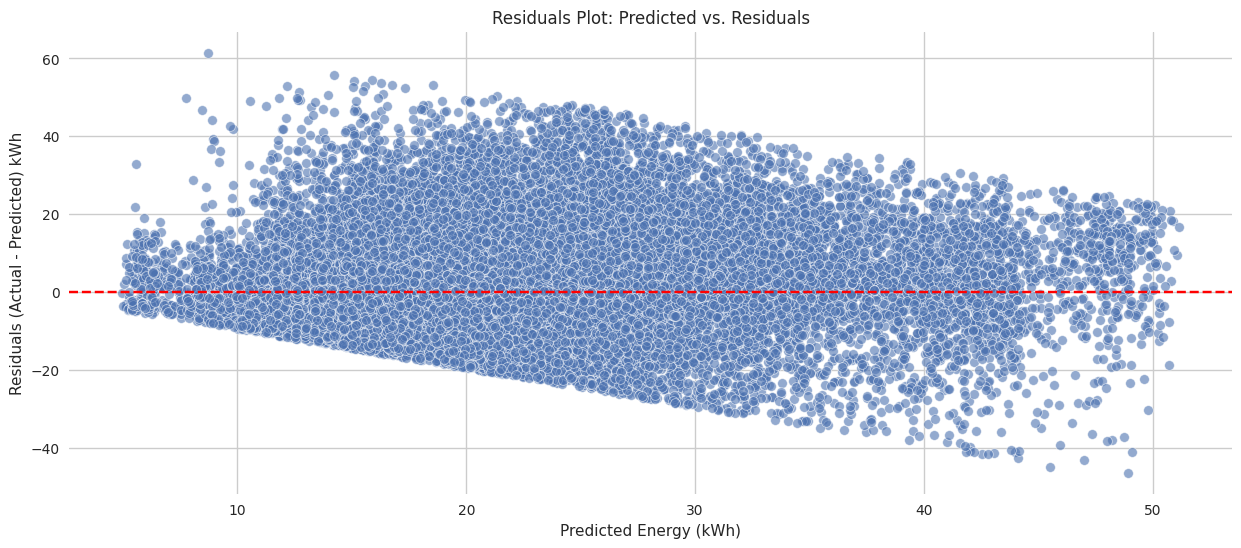

<Figure size 1000x800 with 0 Axes>

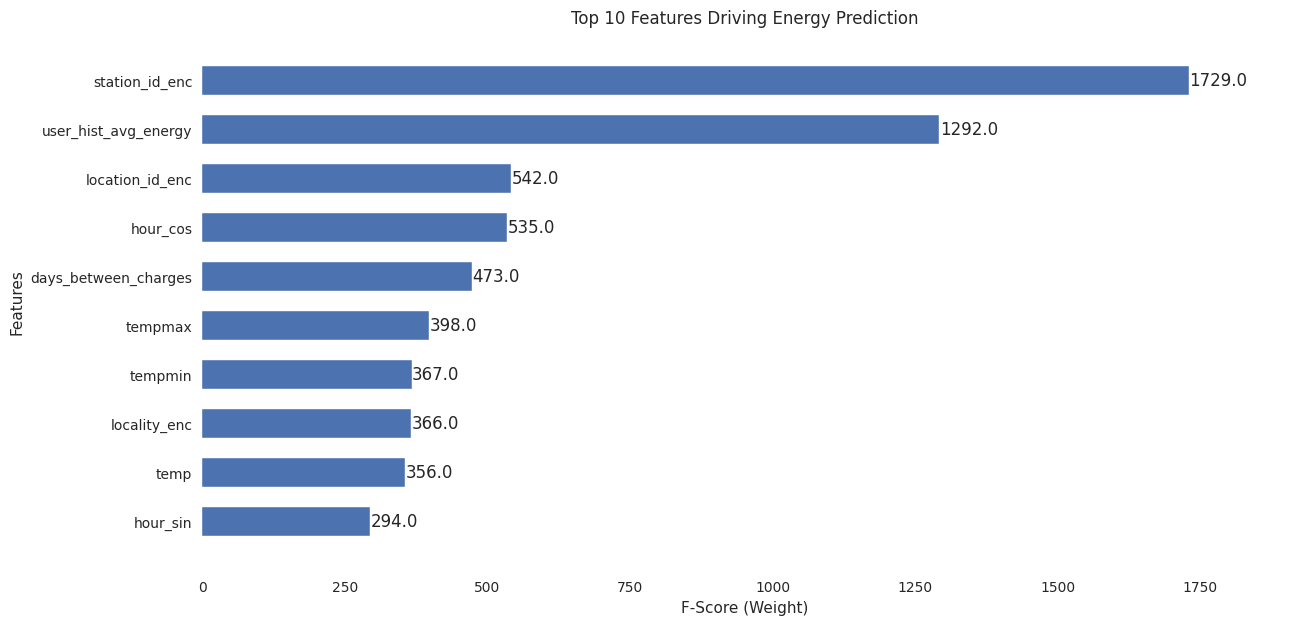

In [33]:
def plot_performance(model, y_test, y_pred):
    """
    Generates plots for Predicted vs Actual, Residuals, and Feature Importance.
    """
    # 1. Prediction vs Actual (First 150 samples for clarity)
    plt.figure(figsize=(15, 6))
    plt.plot(y_test.values[:150], label='Actual Energy', color='black', alpha=0.7)
    plt.plot(y_pred[:150], label='Predicted Energy (XGBoost)', color='#00CC96', linestyle='--')
    plt.title("Forecasting Performance: Actual vs Predicted Energy (Subset)")
    plt.xlabel("Session Index")
    plt.ylabel("Energy (kWh)")
    plt.legend()
    plt.show()

    # 2. Residuals Plot
    residuals = y_test - y_pred
    plt.figure(figsize=(15, 6))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residuals Plot: Predicted vs. Residuals')
    plt.xlabel('Predicted Energy (kWh)')
    plt.ylabel('Residuals (Actual - Predicted) kWh')
    plt.show()

    # 3. Feature Importance
    plt.figure(figsize=(10, 8))
    xgb.plot_importance(model, importance_type='weight', max_num_features=10,
                        title='Top 10 Features Driving Energy Prediction',
                        xlabel='F-Score (Weight)', height=0.6, grid=False)
    plt.show()

plot_performance(model, y_test, y_pred)